NBA Analysis
Analyzes advanced statistics, creates a regression model to predict salary, and offers preliminary assessment of under-and-over-valued players based on actual salaries relative to the predicted salaries 

In [19]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
# load csv files
# Note: Full script (available in Github repo) scrapes (i) advanced stats and (ii) salary data from Basketballreference.com 
# and puts them into two separate csv files.
# This summary analysis uploads the two csv files as the starting point
df_stats = pd.read_csv('nba_advanced_stats_2025.csv')
df_salary = pd.read_csv('nba_player_salaries_2025.csv')

In [4]:
# Explore data
print(df_stats.columns)
print(df_stats.shape)
print(df_stats.sample(1))
print(df_salary.columns)
print(df_salary.shape)
print(df_salary.sample(1))

Index(['Rk', 'Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'PER', 'TS%',
       '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
       'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP',
       'Awards'],
      dtype='object')
(736, 29)
        Rk                Player   Age Team Pos     G   GS     MP   PER   TS%  \
537  419.0  Terrence Shannon Jr.  24.0  MIN  SG  32.0  1.0  339.0  11.9  0.56   

     ...  USG%  OWS  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP  Awards  
537  ...  17.7  0.3  0.4  0.6  0.091  -2.1   0.0 -2.1   0.0     NaN  

[1 rows x 29 columns]
Index(['Player', 'Salary_2025_26'], dtype='object')
(470, 2)
             Player  Salary_2025_26
77  Trey Murphy III      25000000.0


In [6]:
# Clean the salary data sets 

# check for missing values
print(df_salary.isnull().sum())

# clean up salary data
df_salary_clean = df_salary.dropna(subset=['Salary_2025_26'])
print(df_salary_clean.isnull().sum())
print(f"Total players with salary: {len(df_salary_clean)}")

# check for duplicates in Player names in both datasets
print(f"Duplicate players in salary data: {df_salary_clean['Player'].duplicated().sum()}")

# remove duplicates by taking the first entry
df_salary_updated = df_salary_clean.drop_duplicates(subset = ['Player'], keep = 'first')

# reset the index
df_salary_updated = df_salary_updated.reset_index(drop=True)

# check
print(f"Duplicate players in salary data: {df_salary_updated['Player'].duplicated().sum()}")


Player             0
Salary_2025_26    22
dtype: int64
Player            0
Salary_2025_26    0
dtype: int64
Total players with salary: 448
Duplicate players in salary data: 9
Duplicate players in salary data: 0


In [7]:
# clean the stats data set

# check for duplicates in Player names
print(f"Duplicate players in stats data: {df_stats['Player'].duplicated().sum()}")

# identify players who appear multiple times
player_counts = df_stats['Player'].value_counts()
print(player_counts)
duplicated_players = player_counts[player_counts > 1].index
print(duplicated_players)

# if players have multile entries, keep the instance with 2TM or 3TM, otherwise keep the first occurrence
def keep_combined_stats(group):
    # check if there's a 2TM or 3TM entry
    combined_entry = group[group['Team'].isin(['2TM', '3TM'])]
    if len(combined_entry) > 0:
        return combined_entry
    else:
        # if no combined entry, return the original entry 
        return group 
    
# apply the function to each group of duplicated players
df_stats_cleaned = df_stats.groupby('Player', group_keys=False).apply(keep_combined_stats)

# reset index after groupby operation
df_stats_cleaned = df_stats_cleaned.reset_index(drop=True)

Duplicate players in stats data: 166
Player
Dennis Schröder     4
Colin Castleton     4
David Roddy         4
MarJon Beauchamp    4
Cody Martin         3
                   ..
James Wiseman       1
Alondes Williams    1
Zyon Pullin         1
Jahlil Okafor       1
Jayson Tatum        1
Name: count, Length: 570, dtype: int64
Index(['Dennis Schröder', 'Colin Castleton', 'David Roddy', 'MarJon Beauchamp',
       'Cody Martin', 'Kyle Kuzma', 'Zach Collins', 'Jake LaRavia',
       'Jonas Valančiūnas', 'Bogdan Bogdanović', 'Luka Dončić', 'Terance Mann',
       'Javonte Green', 'Nick Richards', 'Jusuf Nurkić', 'Caris LeVert',
       'Jimmy Butler', 'Kevin Porter Jr.', 'D'Angelo Russell', 'De'Aaron Fox',
       'De'Andre Hunter', 'Caleb Martin', 'Kyle Anderson', 'Ben Simmons',
       'Davion Mitchell', 'Andrew Wiggins', 'Quentin Grimes', 'Anthony Davis',
       'KJ Martin', 'Georges Niang', 'Thomas Bryant', 'Bruce Brown',
       'Kevin Huerter', 'Dorian Finney-Smith', 'Tre Jones', 'Kelly Olynyk

C:\Users\elder\AppData\Local\Temp\ipykernel_22440\1444079688.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_stats_cleaned = df_stats.groupby('Player', group_keys=False).apply(keep_combined_stats)


In [8]:
# check for duplicated players again
print(f"Duplicate players in cleaned stats data: {df_stats_cleaned['Player'].duplicated().sum()}")


Duplicate players in cleaned stats data: 0


In [11]:
# Merge datasets on Player name
df_merged = pd.merge(df_stats_cleaned, df_salary_updated[['Player', 'Salary_2025_26']], on='Player', how='inner')
print(f"Merged dataset shape: {df_merged.shape}")
print(f"Duplicate players in cleaned stats data: {df_merged['Player'].duplicated().sum()}")
print(df_merged.columns)

Merged dataset shape: (399, 30)
Duplicate players in cleaned stats data: 0
Index(['Rk', 'Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'PER', 'TS%',
       '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
       'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP',
       'Awards', 'Salary_2025_26'],
      dtype='object')


In [13]:
# convert salary to millions for easier visuals
df_merged['Salary_Millions'] = df_merged['Salary_2025_26'] / 1_000_000


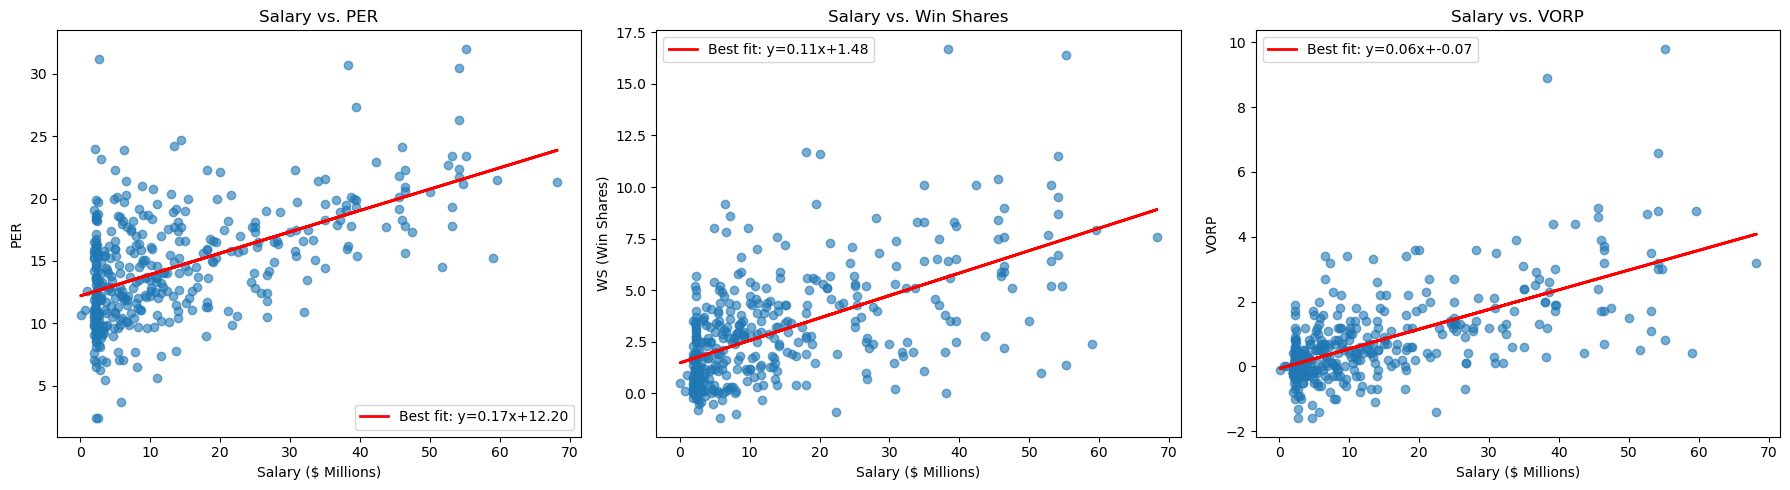

In [16]:
# scatter plot of salary vs. different features 

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Function to add best fit line
def add_best_fit(ax, x, y):
    # Remove any NaN values
    mask = ~np.isnan(x) & ~np.isnan(y)
    x_clean = x[mask]
    y_clean = y[mask]
    
    # Calculate best fit line
    z = np.polyfit(x_clean, y_clean, 1)
    p = np.poly1d(z)
    
    # Add line to plot
    ax.plot(x_clean, p(x_clean), "r-", linewidth=2, label=f'Best fit: y={z[0]:.2f}x+{z[1]:.2f}')
    ax.legend()

# Scatter plot 1: Salary vs. PER
axes[0].scatter(df_merged['Salary_Millions'], df_merged['PER'], alpha=0.6)
add_best_fit(axes[0], df_merged['Salary_Millions'].values, df_merged['PER'].values)
axes[0].set_xlabel('Salary ($ Millions)')
axes[0].set_ylabel('PER')
axes[0].set_title('Salary vs. PER')

# Scatter plot 2: Salary vs. WS
axes[1].scatter(df_merged['Salary_Millions'], df_merged['WS'], alpha=0.6)
add_best_fit(axes[1], df_merged['Salary_Millions'].values, df_merged['WS'].values)
axes[1].set_xlabel('Salary ($ Millions)')
axes[1].set_ylabel('WS (Win Shares)')
axes[1].set_title('Salary vs. Win Shares')

# Scatter plot 3: Salary vs. VORP
axes[2].scatter(df_merged['Salary_Millions'], df_merged['VORP'], alpha=0.6)
add_best_fit(axes[2], df_merged['Salary_Millions'].values, df_merged['VORP'].values)
axes[2].set_xlabel('Salary ($ Millions)')
axes[2].set_ylabel('VORP')
axes[2].set_title('Salary vs. VORP')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [18]:
# examine correlations of salary vs. each feature variable 

# Calculate correlations with salary (only numeric columns)
salary_correlations = df_merged.corr(numeric_only=True)['Salary_Millions'].sort_values(ascending=False)

# Display the correlations
print("Correlation with Salary:")
print(salary_correlations)

Correlation with Salary:
Salary_2025_26     1.000000
Salary_Millions    1.000000
VORP               0.650991
OBPM               0.628589
USG%               0.609878
GS                 0.606605
WS                 0.586841
OWS                0.569486
MP                 0.550650
PER                0.548386
BPM                0.544793
AST%               0.513038
DWS                0.476115
Age                0.309004
WS/48              0.298395
FTr                0.241541
G                  0.213706
TS%                0.153046
DRB%               0.136852
TRB%               0.033412
DBPM               0.014921
STL%              -0.038989
BLK%              -0.040523
TOV%              -0.056737
ORB%              -0.141925
3PAr              -0.150983
Rk                -0.529783
Awards                  NaN
Name: Salary_Millions, dtype: float64


MODEL PERFORMANCE

Training Set:
  R² Score: 0.6448
  RMSE: $8.44M
  MAE: $6.35M

Test Set:
  R² Score: 0.5303
  RMSE: $10.62M
  MAE: $8.20M

FEATURE COEFFICIENTS
Feature  Coefficient
  WS/48    30.775728
    BPM     1.035923
   VORP     0.996635
   USG%     0.908747
     WS     0.522539
   AST%     0.071976
   TRB%     0.039296
     MP     0.011730
    PER    -0.246594
      G    -0.322371
   OBPM    -0.475316
   DBPM    -1.056801
    TS%   -18.516888

Intercept: $6.40M


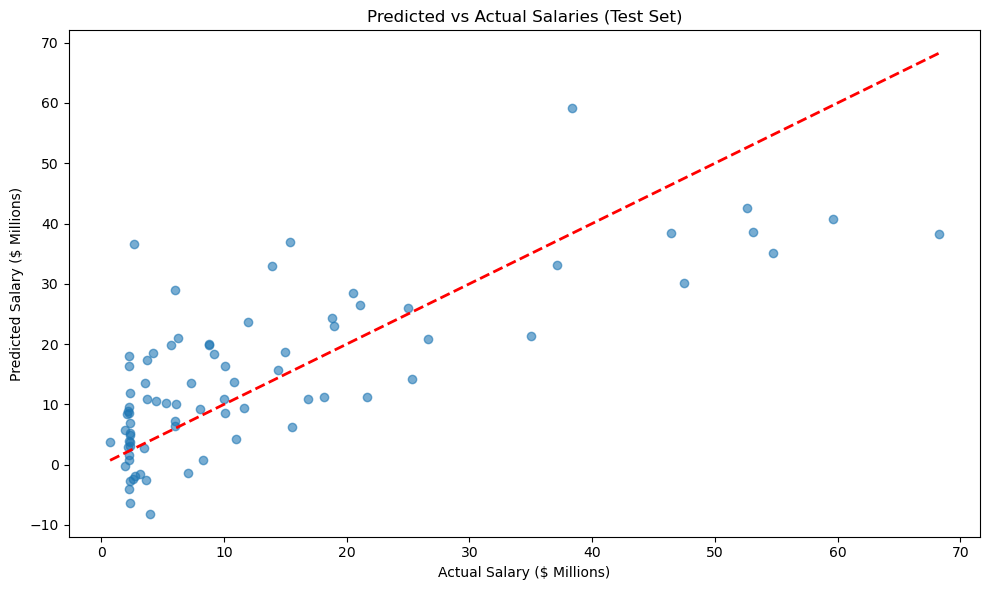

In [ ]:
# create a multi-linear regression analysis to predict salaries

# Select features for the model (all numeric columns except salary columns)
features_to_use = ['PER', 'TS%', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 
                   'MP', 'G', 'USG%', 'AST%', 'TRB%']

# Remove rows with missing values in the features we're using
df_model = df_merged[features_to_use + ['Salary_Millions']].dropna()

# Separate features (X) and target variable (y)
X = df_model[features_to_use]
y = df_model['Salary_Millions']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
print("=" * 60)
print("MODEL PERFORMANCE")
print("=" * 60)
print(f"\nTraining Set:")
print(f"  R² Score: {r2_score(y_train, y_pred_train):.4f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}M")
print(f"  MAE: ${mean_absolute_error(y_train, y_pred_train):.2f}M")

print(f"\nTest Set:")
print(f"  R² Score: {r2_score(y_test, y_pred_test):.4f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}M")
print(f"  MAE: ${mean_absolute_error(y_test, y_pred_test):.2f}M")

# Show feature coefficients (which features matter most)
print("\n" + "=" * 60)
print("FEATURE COEFFICIENTS")
print("=" * 60)
coefficients = pd.DataFrame({
    'Feature': features_to_use,
    'Coefficient': model.coef_
}).sort_values('Coefficient', ascending=False)
print(coefficients.to_string(index=False))

print(f"\nIntercept: ${model.intercept_:.2f}M")

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Salary ($ Millions)')
plt.ylabel('Predicted Salary ($ Millions)')
plt.title('Predicted vs Actual Salaries (Test Set)')
plt.tight_layout()
plt.show()

SIMPLE LINEAR REGRESSION (VORP ONLY)

Training Set:
  R² Score: 0.3959
  RMSE: $11.01M
  MAE: $8.24M

Test Set:
  R² Score: 0.5099
  RMSE: $10.85M
  MAE: $8.64M

MODEL EQUATION
Salary = 6.78 × VORP + 8.97


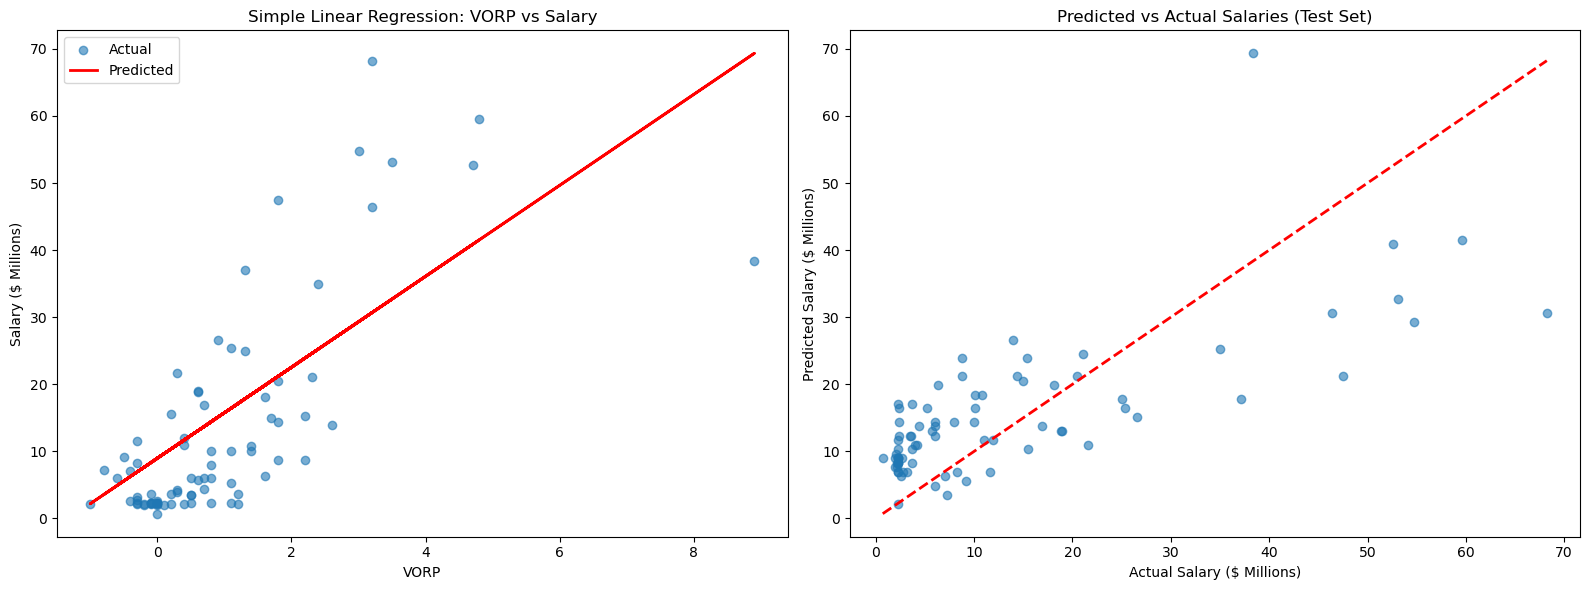

In [22]:
# look at performance of regression analysis with only one feature

# Remove rows with missing values
df_simple = df_merged[['VORP', 'Salary_Millions']].dropna()

# Separate features (X) and target variable (y)
X_simple = df_simple[['VORP']]  # Need double brackets to keep it as DataFrame
y_simple = df_simple['Salary_Millions']

# Split data into training and testing sets (80% train, 20% test)
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(
    X_simple, y_simple, test_size=0.2, random_state=42
)

# Create and train the model
model_simple = LinearRegression()
model_simple.fit(X_train_simple, y_train_simple)

# Make predictions
y_pred_train_simple = model_simple.predict(X_train_simple)
y_pred_test_simple = model_simple.predict(X_test_simple)

# Evaluate the model
print("=" * 60)
print("SIMPLE LINEAR REGRESSION (VORP ONLY)")
print("=" * 60)
print(f"\nTraining Set:")
print(f"  R² Score: {r2_score(y_train_simple, y_pred_train_simple):.4f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_train_simple, y_pred_train_simple)):.2f}M")
print(f"  MAE: ${mean_absolute_error(y_train_simple, y_pred_train_simple):.2f}M")

print(f"\nTest Set:")
print(f"  R² Score: {r2_score(y_test_simple, y_pred_test_simple):.4f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test_simple, y_pred_test_simple)):.2f}M")
print(f"  MAE: ${mean_absolute_error(y_test_simple, y_pred_test_simple):.2f}M")

print("\n" + "=" * 60)
print("MODEL EQUATION")
print("=" * 60)
print(f"Salary = {model_simple.coef_[0]:.2f} × VORP + {model_simple.intercept_:.2f}")

# Visualize predictions vs actual values
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scatter plot with regression line
axes[0].scatter(X_test_simple, y_test_simple, alpha=0.6, label='Actual')
axes[0].plot(X_test_simple, y_pred_test_simple, 'r-', linewidth=2, label='Predicted')
axes[0].set_xlabel('VORP')
axes[0].set_ylabel('Salary ($ Millions)')
axes[0].set_title('Simple Linear Regression: VORP vs Salary')
axes[0].legend()

# Plot 2: Predicted vs Actual
axes[1].scatter(y_test_simple, y_pred_test_simple, alpha=0.6)
axes[1].plot([y_test_simple.min(), y_test_simple.max()], 
             [y_test_simple.min(), y_test_simple.max()], 'r--', linewidth=2)
axes[1].set_xlabel('Actual Salary ($ Millions)')
axes[1].set_ylabel('Predicted Salary ($ Millions)')
axes[1].set_title('Predicted vs Actual Salaries (Test Set)')

plt.tight_layout()
plt.show()

In [26]:
# Create a dataframe with actual vs predicted salaries
# Get the player names and age from the original df_merged using the index
player_names = df_merged.loc[X_test.index, 'Player']
player_ages = df_merged.loc[X_test.index, 'Age']

results_df = pd.DataFrame({
    'Player': player_names.values,
    'Age': player_ages.values,
    'Actual_Salary_Millions': y_test.values,
    'Predicted_Salary_Millions': y_pred_test,
    'Difference_Millions': y_test.values - y_pred_test,
    'Percent_Error': ((y_test.values - y_pred_test) / y_test.values * 100)
})

# Sort by absolute difference to see biggest prediction errors
results_df['Abs_Difference'] = results_df['Difference_Millions'].abs()
results_df = results_df.sort_values('Abs_Difference', ascending=False)

# Display the results
print("=" * 80)
print("ACTUAL vs PREDICTED SALARIES (Multi-Linear Regression)")
print("=" * 80)
print(results_df[['Player', 'Age', 'Actual_Salary_Millions', 'Predicted_Salary_Millions', 
                  'Difference_Millions', 'Percent_Error']].to_string(index=False))

# Show some summary statistics
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)
print(f"Most Overpaid (Model predicts lower): {results_df.iloc[0]['Player']} (Age {results_df.iloc[0]['Age']})")
print(f"  Actual: ${results_df.iloc[0]['Actual_Salary_Millions']:.2f}M")
print(f"  Predicted: ${results_df.iloc[0]['Predicted_Salary_Millions']:.2f}M")
print(f"  Overpaid by: ${results_df.iloc[0]['Difference_Millions']:.2f}M")

most_underpaid = results_df[results_df['Difference_Millions'] < 0].iloc[0]
print(f"\nMost Underpaid (Model predicts higher): {most_underpaid['Player']} (Age {most_underpaid['Age']})")
print(f"  Actual: ${most_underpaid['Actual_Salary_Millions']:.2f}M")
print(f"  Predicted: ${most_underpaid['Predicted_Salary_Millions']:.2f}M")
print(f"  Underpaid by: ${-most_underpaid['Difference_Millions']:.2f}M")

# Optionally save to CSV
results_df.to_csv('salary_predictions.csv', index=False)
print("\nResults saved to 'salary_predictions.csv'")

ACTUAL vs PREDICTED SALARIES (Multi-Linear Regression)
                  Player  Age  Actual_Salary_Millions  Predicted_Salary_Millions  Difference_Millions  Percent_Error
           James Wiseman 23.0                2.667947                  36.588202           -33.920255   -1271.399117
          Damian Lillard 34.0               68.230450                  38.271098            29.959352      43.909065
              Cam Thomas 23.0                5.993172                  28.962163           -22.968991    -383.252657
          Paolo Banchero 22.0               15.334769                  36.970741           -21.635972    -141.090956
 Shai Gilgeous-Alexander 26.0               38.333050                  59.233000           -20.899950     -54.522011
            Kevin Durant 36.0               54.708609                  35.042569            19.666040      35.946884
           Austin Reaves 26.0               13.937574                  32.874495           -18.936921    -135.869561
         